In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
from matplotlib import pyplot as plt
from common import CirclesSampleable, MoonsSampleable, CheckerboardSampleable, hist2d_sampleable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


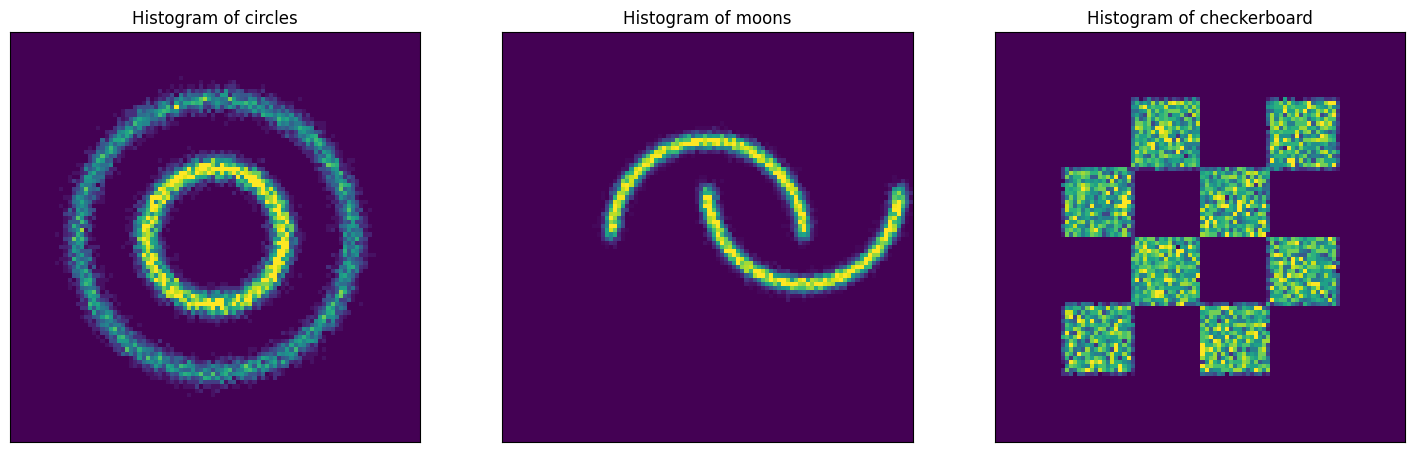

In [13]:
# Visualize alternative choices of p_data
targets = {
    "circles": CirclesSampleable(device),
    "moons": MoonsSampleable(device, scale=3.5),
    "checkerboard": CheckerboardSampleable(device, grid_size=4)
}

###################################
# Graph Various Choices of p_data #
###################################

fig, axes = plt.subplots(1, len(targets), figsize=(6 * len(targets), 6))

num_samples = 20000
num_bins = 100
for idx, (target_name, target) in enumerate(targets.items()):
    ax = axes[idx]
    hist2d_sampleable(target, num_samples, bins=num_bins, scale=7.5, ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Histogram of {target_name}')

plt.show()

In [28]:
from common import Gaussian, LinearConditionalProbabilityPath, hist2d_samples,ConditionalVectorFieldODE,EulerSimulator,record_every

100%|██████████| 499/499 [00:00<00:00, 6530.39it/s]


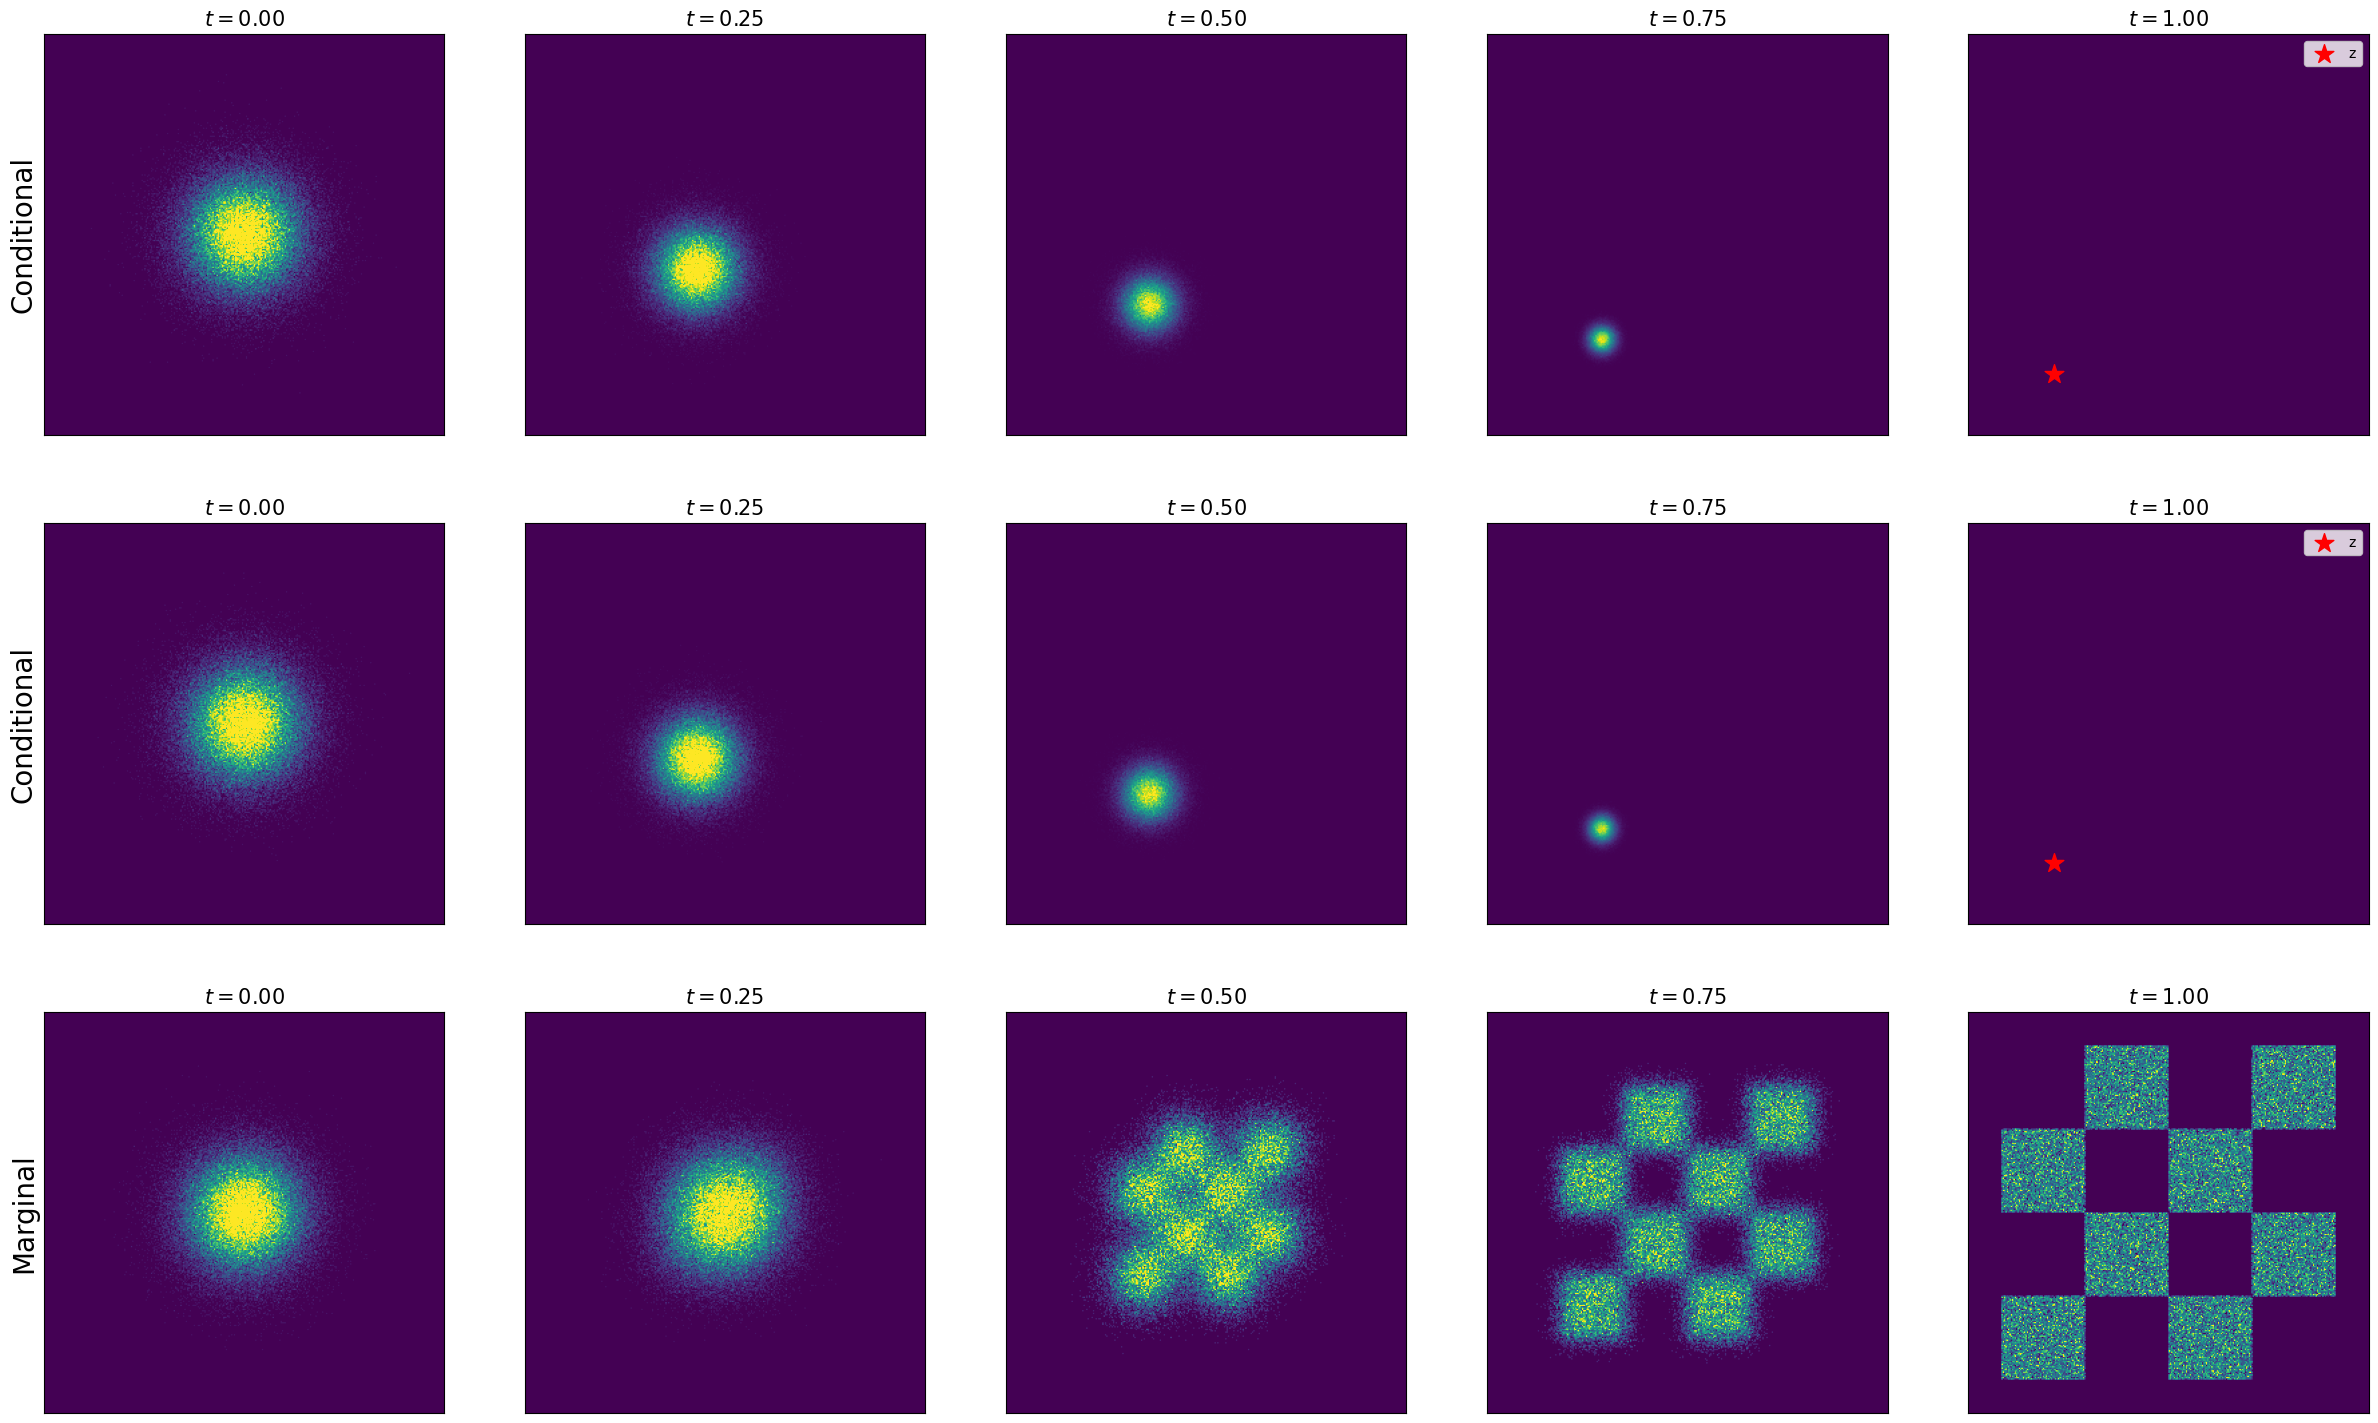

In [30]:
##########################
# Play around with these #
##########################
num_samples = 100000
num_timesteps = 500
num_marginals = 5
assert num_timesteps % (num_marginals - 1) == 0

##########################################
# Construct conditional probability path #
##########################################
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)
z = path.p_data.sample(1) # (1,2)

##############
# Setup plots #
##############

fig, axes = plt.subplots(3, num_marginals, figsize=(6 * num_marginals, 6 * 3))
axes = axes.reshape(3, num_marginals)
scale = 6.0


#####################################################################
# Graph conditional probability paths using sample_conditional_path #
#####################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_conditional_path(zz, tt)
    percentile = min(99 + 2 * torch.sin(t).item(), 100)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Conditional", fontsize=20)

# Plot z
axes[0,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[0,-1].legend()

######################################################################
# Graph conditional probability paths using conditional_vector_field #
######################################################################
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,num_timesteps).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    tt = ts[record_every_idxs[idx]]
    percentile = min(99 + 2 * torch.sin(tt).item(), 100)
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Conditional", fontsize=20)

# Plot z
axes[1,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[1,-1].legend()

##################################################################
# Graph conditional probability paths using sample_marginal_path #
##################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[2, idx], bins=300, scale=scale, percentile=99, alpha=1.0)
    axes[2, idx].set_xlim(-scale, scale)
    axes[2, idx].set_ylim(-scale, scale)
    axes[2, idx].set_xticks([])
    axes[2, idx].set_yticks([])
    axes[2, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[2, 0].set_ylabel("Marginal", fontsize=20)

plt.show()

In [34]:
from common import MLPVectorField, ConditionalFlowMatchingTrainer

In [35]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model)
losses = trainer.train(num_epochs=10000, device=device, lr=1e-3, batch_size=2000)

Epoch 9999, loss: 8.85042667388916: : 10000it [00:26, 377.70it/s] 


In [37]:
from common import LearnedVectorFieldODE

100%|██████████| 99/99 [00:00<00:00, 125.28it/s]


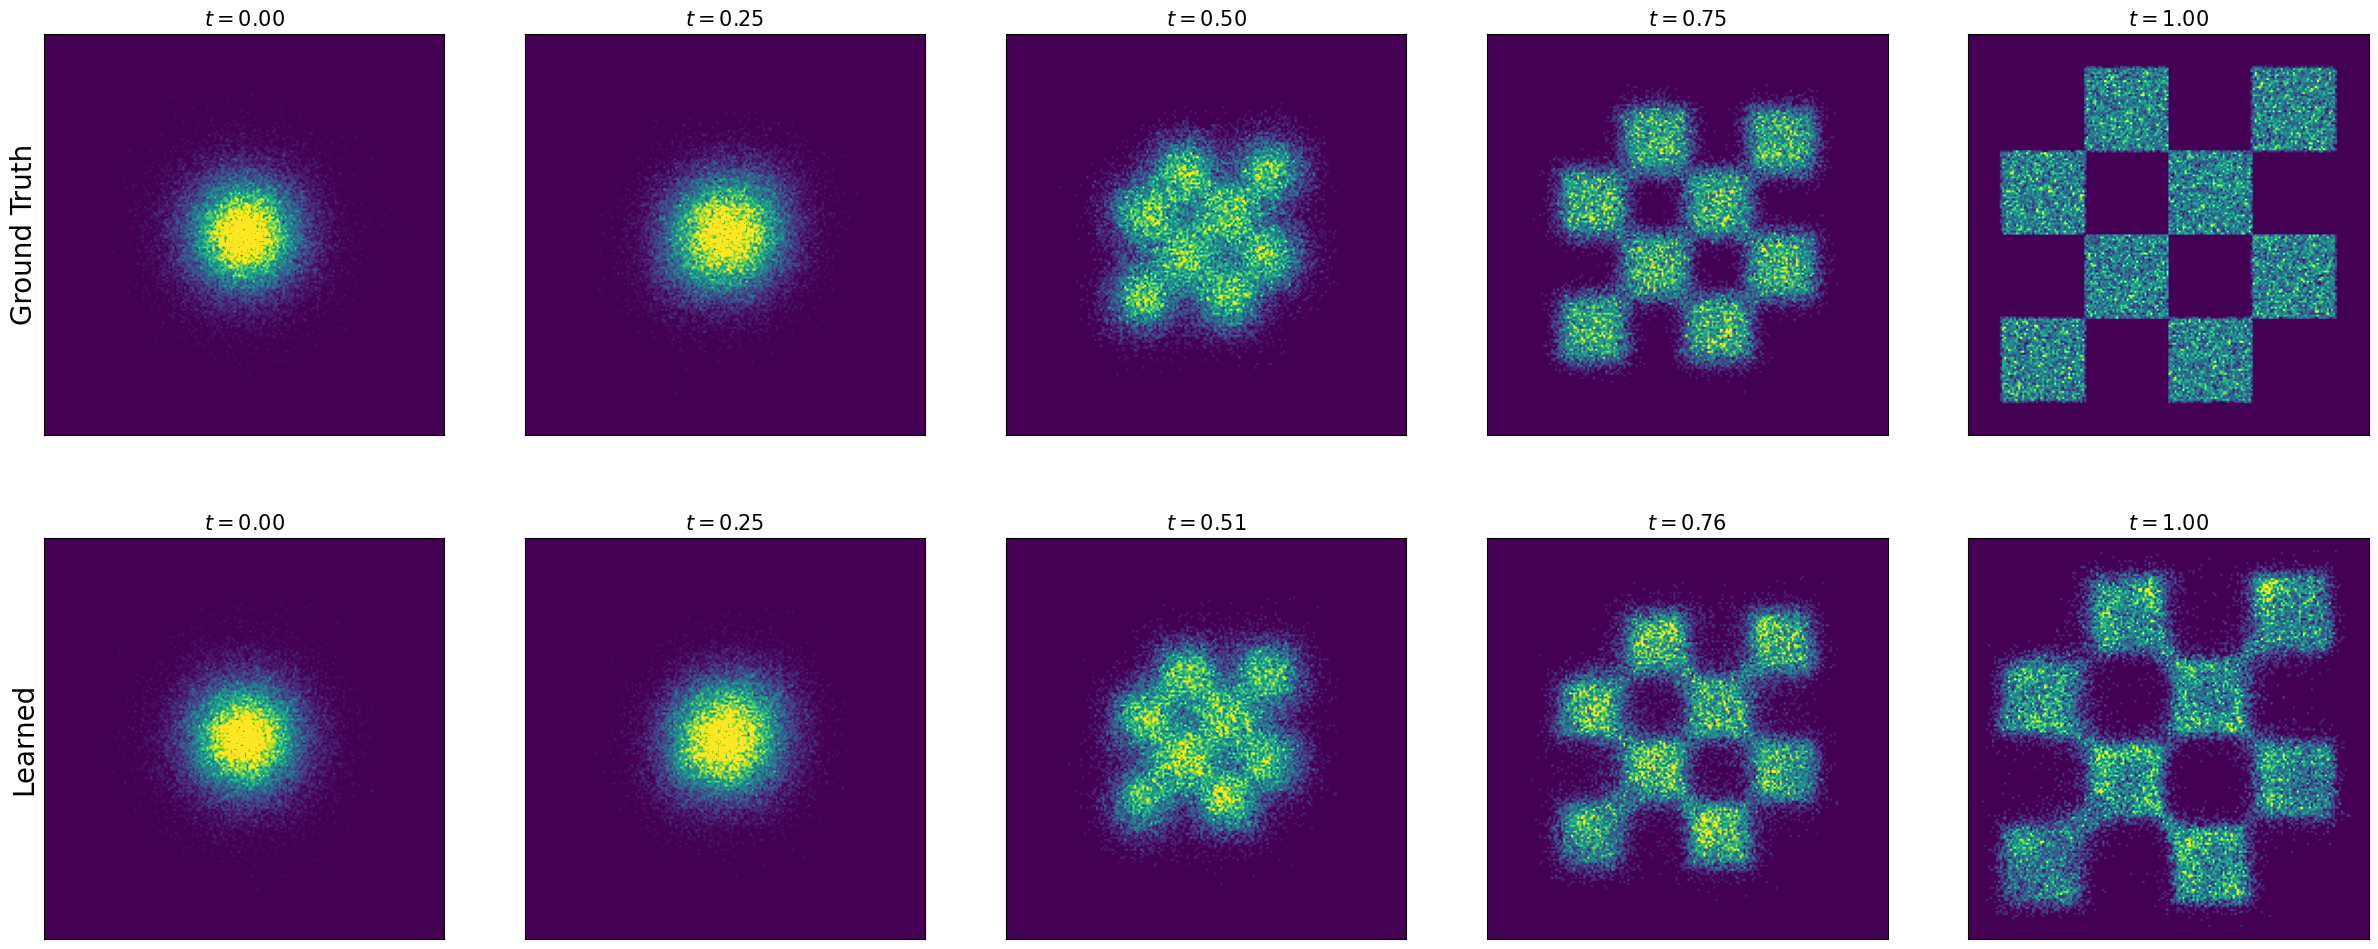

In [38]:
##########################
# Play around With These #
##########################
num_samples = 50000
num_marginals = 5

##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0

###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Marginals of Learned Vector Field #
###############################################
ode = LearnedVectorFieldODE(linear_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,100).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()

In [39]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = CirclesSampleable(device),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
bridging_flow_model = MLPVectorField(dim=2, hiddens=[100,100,100,100])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, bridging_flow_model)
losses = trainer.train(num_epochs=20000, device=device, lr=1e-3, batch_size=2000)

Epoch 19999, loss: 21.489559173583984: : 20000it [01:07, 297.42it/s]


100%|██████████| 199/199 [00:01<00:00, 120.54it/s]


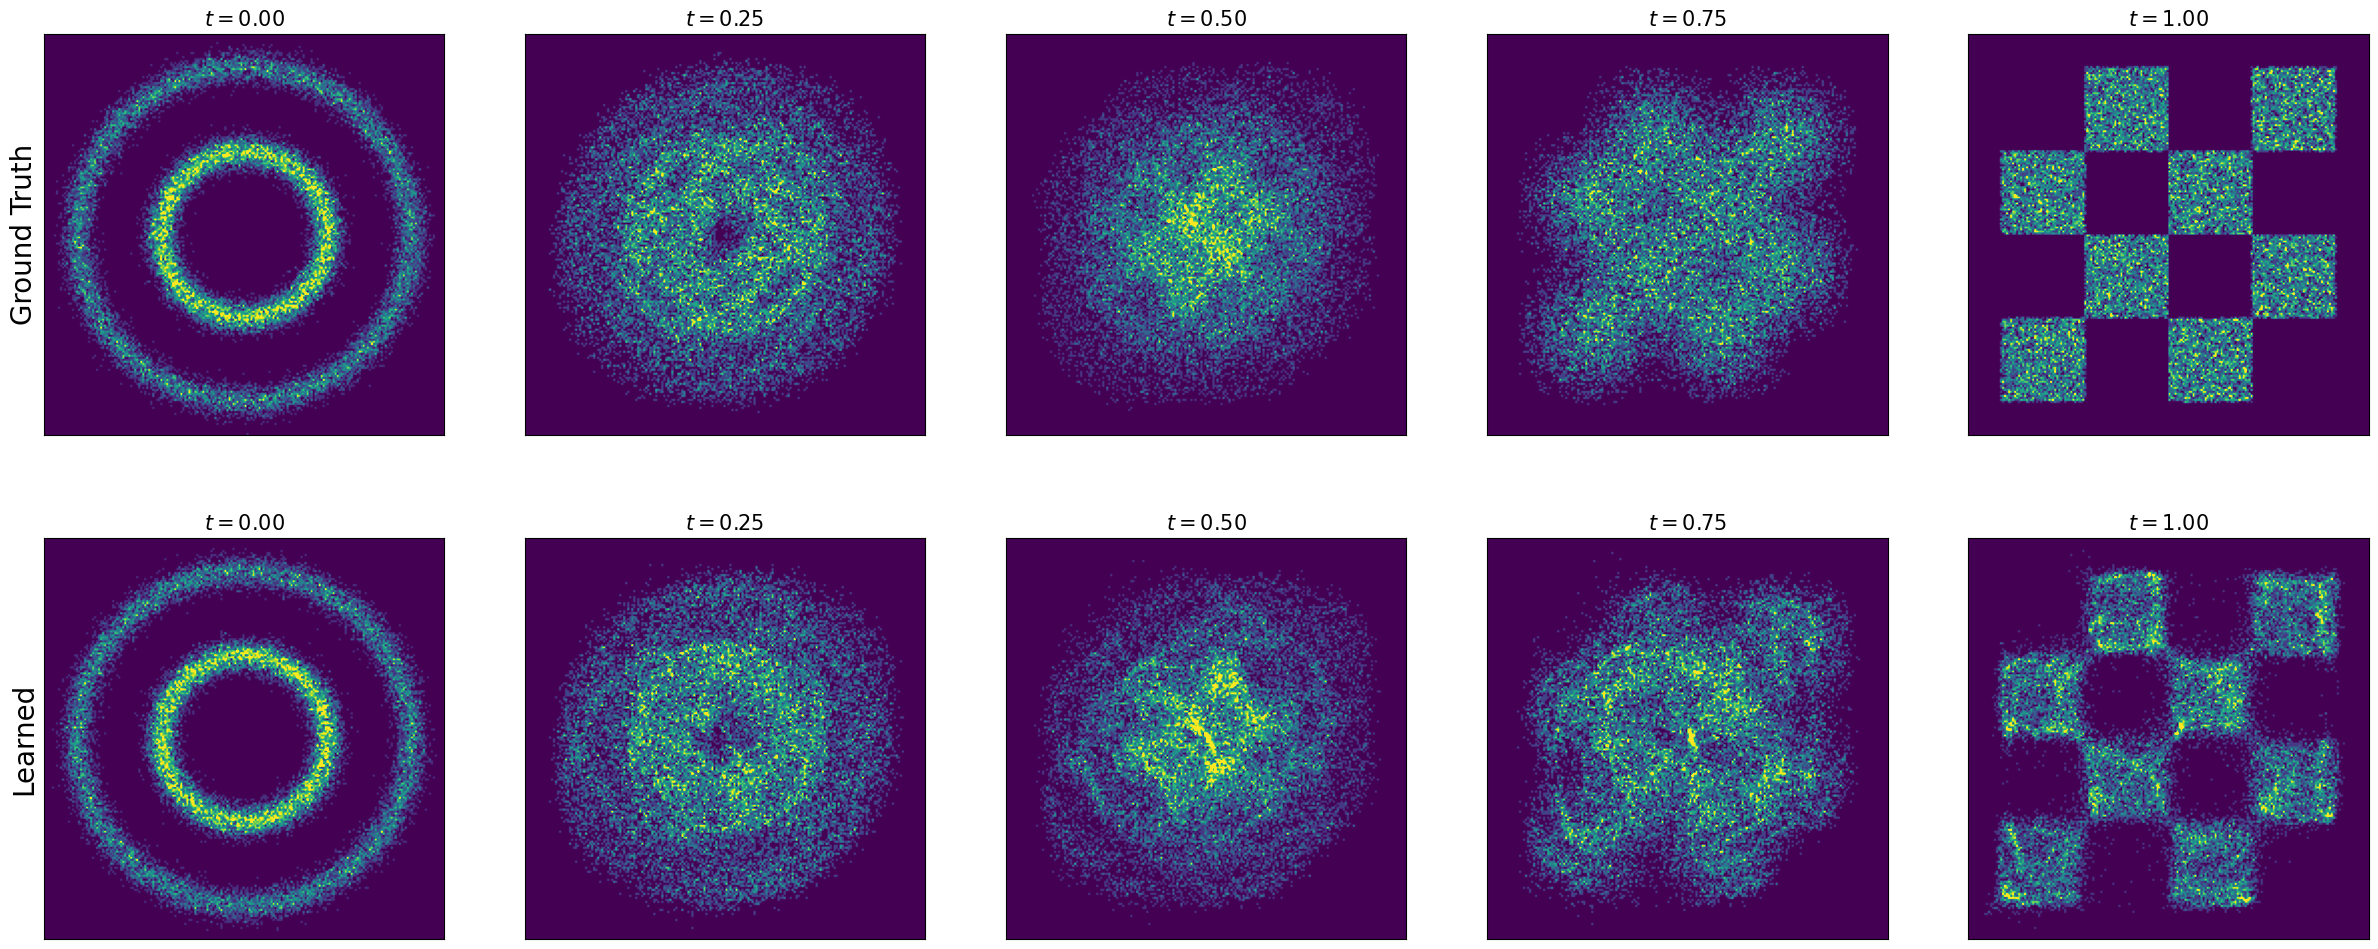

In [40]:
##########################
# Play around With These #
##########################
num_samples = 30000
num_marginals = 5


##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0


###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Learned Marginals #
###############################################
ode = LearnedVectorFieldODE(bridging_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,200).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()